# XLnet

In [ ]:
!pip install pytorch-transformers
!pip install transformers
!pip install nltk
!pip install preprocessor
!pip install tweet-preprocessor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.4/176.4 KB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 KB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 71.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 880.6/880.6 KB 64.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.6/79.6 KB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.6/10.6 MB 59.1 MB/s eta 0:00:00
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895259 sha256=ba91bd170017b73a438834d34b808c67183a525a9762e34afa58a9a19b4dcebc
  Stored in directory: /root/.cache/pip/wheels/12/1c/3d/46cf06718d63a32ff798a89594b61e7f345ab6b36d909ce033
Successfully built sacremoses
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-whe

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
import torch
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.utils import pad_sequences
from sklearn.model_selection import train_test_split
import preprocessor as p

from transformers import XLNetTokenizer, XLNetForSequenceClassification
from transformers import XLMModel, BertTokenizer, BertForSequenceClassification, RobertaTokenizerFast, RobertaForSequenceClassification
from transformers import AdamW
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
# % matplotlib inline

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla T4'

In [ ]:
MAX_LEN = 128

In [ ]:
df = pd.read_csv("Constraint_Train.csv")
val_df = pd.read_csv("Constraint_Val.csv")
test_df = pd.read_csv("english_test_with_labels.csv")
test_label_df = pd.read_csv('english_test_with_labels.csv')

In [ ]:
df.shape, val_df.shape, test_df.shape

((6420, 3), (2140, 3), (2140, 3))

In [ ]:
df.head()

,id,tweet,label
0,1,The CDC currently reports 99031 deaths. In gen...,real
1,2,States reported 1121 deaths a small rise from ...,real
2,3,Politically Correct Woman (Almost) Uses Pandem...,fake
3,4,#IndiaFightsCorona: We have 1524 #COVID testin...,real
4,5,Populous states can generate large case counts...,real


In [ ]:
wordnet_lemmatizer = WordNetLemmatizer()
porter_stemmer  = PorterStemmer()

## data preprocess

In [ ]:
p.set_options(p.OPT.URL, p.OPT.EMOJI)

def preprocess(row, lemmatizer, stemmer):
  text = row['tweet']
  # text = text.strip('\xa0')
  text = p.clean(text)
  tokenization = nltk.word_tokenize(text)     
  tokenization = [w for w in tokenization if not w in stop_words]
    
  return text

In [ ]:
df['tweet'] = df.apply(lambda x: preprocess(x, wordnet_lemmatizer, porter_stemmer), 1)
val_df['tweet'] = val_df.apply(lambda x: preprocess(x, wordnet_lemmatizer, porter_stemmer), 1)
test_df['tweet'] = test_df.apply(lambda x: preprocess(x, wordnet_lemmatizer, porter_stemmer), 1)

In [ ]:
def map_label(row):
  return 0 if row['label']=='real' else 1

df['label_encoded'] = df.apply(lambda x: map_label(x), 1)
val_df['label_encoded'] = val_df.apply(lambda x: map_label(x), 1)
# test_df['label_encoded'] = test_df.apply(lambda x: map_label(x), 1)

In [ ]:
train_sentences = df.tweet.values
val_sentences = val_df.tweet.values
test_sentences = test_df.tweet.values

train_labels = df.label_encoded.values
val_labels = val_df.label_encoded.values

In [ ]:
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased', do_lower_case=False)

In [ ]:
def Encode_TextWithAttention(sentence,tokenizer,maxlen,padding_type='max_length',attention_mask_flag=True):
    encoded_dict = tokenizer.encode_plus(sentence, add_special_tokens=True, max_length=maxlen, truncation=True, padding=padding_type, 
                                         return_attention_mask=attention_mask_flag)
    return encoded_dict['input_ids'],encoded_dict['attention_mask']

def Encode_TextWithoutAttention(sentence,tokenizer,maxlen,padding_type='max_length',attention_mask_flag=False):
    encoded_dict = tokenizer.encode_plus(sentence, add_special_tokens=True, max_length=maxlen, truncation=True, padding=padding_type, return_attention_mask=attention_mask_flag)
    return encoded_dict['input_ids']

def get_TokenizedTextWithAttentionMask(sentenceList, tokenizer):
    token_ids_list,attention_mask_list = [],[]
    for sentence in sentenceList:
        token_ids,attention_mask = Encode_TextWithAttention(sentence,tokenizer,MAX_LEN)
        token_ids_list.append(token_ids)
        attention_mask_list.append(attention_mask)
    return token_ids_list,attention_mask_list

def get_TokenizedText(sentenceList, tokenizer):
    token_ids_list = []
    for sentence in sentenceList:
        token_ids = Encode_TextWithoutAttention(sentence,tokenizer,MAX_LEN)
        token_ids_list.append(token_ids)
    return token_ids_list

In [ ]:
train_token_ids,train_attention_masks = torch.tensor(get_TokenizedTextWithAttentionMask(train_sentences,tokenizer))
val_token_ids,val_attention_masks = torch.tensor(get_TokenizedTextWithAttentionMask(val_sentences,tokenizer))
test_token_ids,test_attention_masks = torch.tensor(get_TokenizedTextWithAttentionMask(test_sentences,tokenizer))

train_labels = torch.tensor(train_labels)
val_labels = torch.tensor(val_labels)

In [ ]:
batch_size = 48

train_data = TensorDataset(train_token_ids, train_attention_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(val_token_ids, val_attention_masks, val_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

test_data = TensorDataset(test_token_ids, test_attention_masks)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

In [ ]:
model = XLNetForSequenceClassification.from_pretrained("xlnet-base-cased", num_labels=2).cuda()

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.bias', 'sequence_summary.summary.weight', 'logits_proj.weight', 'logits_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a

In [ ]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

In [ ]:
optimizer = torch.optim.AdamW(optimizer_grouped_parameters, lr=2e-5)

In [ ]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
train_loss_set = []
best_val_accuracy = 0.90
directory_path = ''
epochs = 15

for _ in trange(epochs, desc="Epoch"):
  
  model.train()
  
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  
  for step, batch in enumerate(train_dataloader):
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch
    optimizer.zero_grad()
    outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    loss = outputs[0]
    logits = outputs[1]
    train_loss_set.append(loss.item())    
    loss.backward()
    optimizer.step()
        
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))
    
  model.eval()

  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0

  for batch in validation_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch
    with torch.no_grad():
      output = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
      logits = output[0]
    
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))
  Validation_Accuracy = (eval_accuracy/nb_eval_steps)
  if(Validation_Accuracy >= best_val_accuracy):
    torch.save(model.state_dict(), directory_path+'./XLNet_base_best_model.ckpt')
    best_val_accuracy = Validation_Accuracy
    print('Model Saved')


Epoch:   0%|          | 0/15 [00:00<?, ?it/s]

Train loss: 0.2570747789551518
Validation Accuracy: 0.9564814814814813


Epoch:   7%|▋         | 1/15 [03:19<46:34, 199.60s/it]

Model Saved
Train loss: 0.10719192145503502
Validation Accuracy: 0.962037037037037


Epoch:  13%|█▎        | 2/15 [06:40<43:27, 200.61s/it]

Model Saved
Train loss: 0.05822301184265082


Epoch:  20%|██        | 3/15 [10:00<40:00, 200.08s/it]

Validation Accuracy: 0.9615740740740741
Train loss: 0.037042245729270375
Validation Accuracy: 0.9662037037037037


Epoch:  27%|██▋       | 4/15 [13:21<36:44, 200.38s/it]

Model Saved
Train loss: 0.03577578561632449
Validation Accuracy: 0.9685185185185188


Epoch:  33%|███▎      | 5/15 [16:41<33:25, 200.52s/it]

Model Saved
Train loss: 0.016469816567589973


Epoch:  40%|████      | 6/15 [20:01<30:02, 200.33s/it]

Validation Accuracy: 0.9640211640211641
Train loss: 0.010483074950231517


Epoch:  47%|████▋     | 7/15 [23:21<26:41, 200.16s/it]

Validation Accuracy: 0.962962962962963
Train loss: 0.021230949616709502
Validation Accuracy: 0.974074074074074


Epoch:  53%|█████▎    | 8/15 [26:43<23:24, 200.58s/it]

Model Saved
Train loss: 0.012562082756793738


Epoch:  60%|██████    | 9/15 [30:02<20:01, 200.31s/it]

Validation Accuracy: 0.9694444444444443
Train loss: 0.006926518781310462


Epoch:  67%|██████▋   | 10/15 [33:22<16:40, 200.20s/it]

Validation Accuracy: 0.9667989417989418
Train loss: 0.011111459095785117


Epoch:  73%|███████▎  | 11/15 [36:42<13:20, 200.05s/it]

Validation Accuracy: 0.96494708994709
Train loss: 0.005445692552807011


Epoch:  80%|████████  | 12/15 [40:02<10:00, 200.01s/it]

Validation Accuracy: 0.9556878306878305
Train loss: 0.011378222065050339


Epoch:  87%|████████▋ | 13/15 [43:21<06:39, 199.77s/it]

Validation Accuracy: 0.9686507936507939
Train loss: 0.0024382336041662033


Epoch:  93%|█████████▎| 14/15 [46:39<03:19, 199.19s/it]

Validation Accuracy: 0.967261904761905
Train loss: 0.0028622825169289023


Epoch: 100%|██████████| 15/15 [49:59<00:00, 199.96s/it]

Validation Accuracy: 0.9686507936507937


## Validation result

0.974074074074074


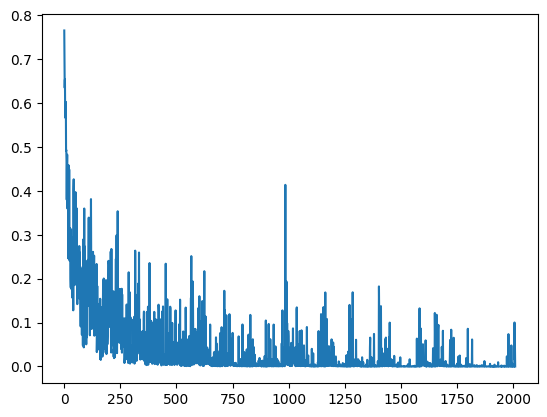

In [ ]:
print(best_val_accuracy)
plt.plot(train_loss_set)

In [ ]:
df = pd.read_csv("Constraint_Train.csv")
val_df = pd.read_csv("Constraint_Val.csv")
test_df = pd.read_csv("english_test_with_labels.csv")
test_label_df = pd.read_csv('english_test_with_labels.csv')

In [ ]:
def map_label(row):
  return 0 if row['label']=='real' else 1

df['label_encoded'] = df.apply(lambda x: map_label(x), 1)
val_df['label_encoded'] = val_df.apply(lambda x: map_label(x), 1)

In [ ]:
train_sentences = df.tweet.values
train_token_ids = df.id.values
val_sentences = val_df.tweet.values
val_token_ids = val_df.id.values
test_sentences = test_df.tweet.values
test_token_ids = test_df.id.values
train_sentences = [sentence + " [SEP] [CLS]" for sentence in train_sentences]
train_labels = df.label_encoded.values
val_sentences = [sentence + " [SEP] [CLS]" for sentence in val_sentences]
val_labels = val_df.label_encoded.values
test_sentences = [sentence + " [SEP] [CLS]" for sentence in test_sentences]
MAX_LEN = 128
batch_size = 64

In [ ]:
def get_dataloader(network, train_sentences, val_sentences, train_labels, val_labels, test_sentences, train_token_ids, val_token_ids, test_token_ids):
  dic = {"XLNET": "xlnet-base-cased", "ROBERT": "roberta-base", "XLM-ROBERT": "xlm-roberta-base", "DeBERTa": "microsoft/deberta-base", "Electra": "google/electra-base-discriminator"}
  if network=='XLNET':
    tokenizer = XLNetTokenizer.from_pretrained(dic[network], do_lower_case=True)
  elif network=='DeBERTa':
    tokenizer = DebertaTokenizer.from_pretrained(dic[network], do_lower_case=True)
  elif network=='Electra':
    tokenizer = ElectraTokenizer.from_pretrained(dic[network], do_lower_case=True)
  elif network=='XLM-ROBERT':
    tokenizer = RobertaTokenizerFast.from_pretrained(dic[network], do_lower_case=True)
  else:
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True) 

  tokenized_train_texts = [tokenizer.tokenize(sent) for sent in train_sentences]
  print ("Tokenize the first sentence:")
  print (tokenized_train_texts[0])

  tokenized_val_texts = [tokenizer.tokenize(sent) for sent in val_sentences]
  tokenized_test_texts = [tokenizer.tokenize(sent) for sent in test_sentences]
  input_train_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_train_texts]
  input_val_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_val_texts]
  input_test_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_test_texts]

  input_train_ids = pad_sequences(input_train_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
  input_val_ids = pad_sequences(input_val_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
  input_test_ids = pad_sequences(input_test_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

  # Create attention masks
  train_attention_masks = []

  # Create a mask of 1s for each token followed by 0s for padding
  for seq in input_train_ids:
    seq_mask = [float(i>0) for i in seq]
    train_attention_masks.append(seq_mask)
  train_masks = np.array(train_attention_masks)

  # Create attention masks
  val_attention_masks = []

  # Create a mask of 1s for each token followed by 0s for padding
  for seq in input_val_ids:
    seq_mask = [float(i>0) for i in seq]
    val_attention_masks.append(seq_mask)
  validation_masks = np.array(val_attention_masks)

  # Create attention masks
  test_attention_masks = []

  # Create a mask of 1s for each token followed by 0s for padding
  for seq in input_test_ids:
    seq_mask = [float(i>0) for i in seq]
    test_attention_masks.append(seq_mask)
  test_masks = np.array(test_attention_masks)

  train_inputs = torch.tensor(input_train_ids)
  validation_inputs = torch.tensor(input_val_ids)
  test_inputs = torch.tensor(input_test_ids)
  train_labels = torch.tensor(train_labels)
  validation_labels = torch.tensor(val_labels)
  train_masks = torch.tensor(train_masks)
  validation_masks = torch.tensor(validation_masks)
  test_masks = torch.tensor(test_masks)

  train_data = TensorDataset(torch.tensor(train_token_ids), train_inputs, train_masks, train_labels)
  train_sampler = RandomSampler(train_data)
  train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

  validation_data = TensorDataset(torch.tensor(val_token_ids), validation_inputs, validation_masks, validation_labels)
  validation_sampler = SequentialSampler(validation_data)
  validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

  test_data = TensorDataset(torch.tensor(test_token_ids), test_inputs, test_masks)
  test_sampler = SequentialSampler(test_data)
  test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

  return train_dataloader, validation_dataloader, test_dataloader

In [ ]:
train_dataloader_XLNET, val_dataloader_XLNET, test_dataloader_XLNET = get_dataloader("XLNET", train_sentences, val_sentences, train_labels, val_labels, test_sentences, train_token_ids, val_token_ids, test_token_ids)


Tokenize the first sentence:
['▁the', '▁c', 'd', 'c', '▁currently', '▁reports', '▁9', '90', '31', '▁deaths', '.', '▁in', '▁general', '▁the', '▁discrepancies', '▁in', '▁death', '▁counts', '▁between', '▁different', '▁sources', '▁are', '▁small', '▁and', '▁', 'exp', 'lic', 'able', '.', '▁the', '▁death', '▁toll', '▁stands', '▁at', '▁roughly', '▁100', '000', '▁people', '▁today', '.', '▁[', 's', 'ep', ']', '▁[', 'cl', 's', ']']


In [ ]:
model3 = XLNetForSequenceClassification.from_pretrained("xlnet-base-cased", num_labels=2)
directory_path = ''
model3.load_state_dict(torch.load('XLNet_base_best_model.ckpt'))
model3.eval()
model3.cuda()

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.bias', 'sequence_summary.summary.weight', 'logits_proj.weight', 'logits_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a

XLNetForSequenceClassification(
  (transformer): XLNetModel(
    (word_embedding): Embedding(32000, 768)
    (layer): ModuleList(
      (0): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (layer_1): Linear(in_features=768, out_features=3072, bias=True)
          (layer_2): Linear(in_features=3072, out_features=768, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (activation_function): GELUActivation()
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (1): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward

In [ ]:
model3 = XLNetForSequenceClassification.from_pretrained("xlnet-base-cased", num_labels=2)
directory_path = ''
model3.load_state_dict(torch.load('XLNet_base_best_model.ckpt'))
model3.eval()
model3.cuda()

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.bias', 'sequence_summary.summary.weight', 'logits_proj.weight', 'logits_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a

XLNetForSequenceClassification(
  (transformer): XLNetModel(
    (word_embedding): Embedding(32000, 768)
    (layer): ModuleList(
      (0): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (layer_1): Linear(in_features=768, out_features=3072, bias=True)
          (layer_2): Linear(in_features=3072, out_features=768, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (activation_function): GELUActivation()
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (1): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward

In [ ]:
def get_model_preds_labels(model, dataloader, mode='train'):
  data_vectors = []
  labels = []
  ids = []

  with torch.no_grad():
      correct = 0
      total = 0
      for i, batch in enumerate(dataloader):
        batch = tuple(t.to(device) for t in batch)
        if mode=='test':
            token_ids, b_input_ids, b_input_mask = batch
            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
            for point, tk_id in zip(F.softmax(outputs.logits).tolist(), token_ids.tolist()):
              data_vectors.append(point)       
              ids.append(tk_id)     
        else:
          # Unpack the inputs from our dataloader
          token_ids, b_input_ids, b_input_mask, b_labels = batch
          # Forward pass
          outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
          for point, lab, tk_id in zip(F.softmax(outputs.logits).tolist(), b_labels.tolist(), token_ids.tolist()):
            data_vectors.append(point)
            labels.append(lab)
            ids.append(tk_id)

  if mode=='test':
    return data_vectors, ids
  else:
    return data_vectors, labels, ids

In [ ]:
m3, _, train_ids3 = get_model_preds_labels(model3, train_dataloader_XLNET)

<ipython-input-71-9113e251b12a>:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  for point, lab, tk_id in zip(F.softmax(outputs.logits).tolist(), b_labels.tolist(), token_ids.tolist()):


In [ ]:
t3, t_ids3 = get_model_preds_labels(model3, test_dataloader_XLNET, 'test')

<ipython-input-71-9113e251b12a>:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  for point, tk_id in zip(F.softmax(outputs.logits).tolist(), token_ids.tolist()):


In [ ]:
test_pred_labels = ["real" if np.argmax(np.array([each]), 1)[0]==0 else "fake" for each in t3]
test_pred_df = pd.DataFrame({'id': t_ids3, 'predicted_label': test_pred_labels})
test_pred_df = test_label_df[["id", "label"]].merge(test_pred_df, on='id', how='left')
test_pred_df.head()

,id,label,predicted_label
0,1,real,real
1,2,fake,fake
2,3,fake,fake
3,4,real,real
4,5,real,real


In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

## Test result


In [ ]:
confusion_matrix(test_pred_df['label'].values, test_pred_df['predicted_label'].values)

array([[ 986,   34],
       [  76, 1044]])

In [ ]:
accuracy_score(test_pred_df['label'].values, test_pred_df['predicted_label'].values)

0.9485981308411215

In [ ]:
precision_score(test_pred_df['label'].values, test_pred_df['predicted_label'].values, average='micro')

0.9485981308411215

In [ ]:
recall_score(test_pred_df['label'].values, test_pred_df['predicted_label'].values, average='micro')

0.9485981308411215

In [ ]:
f1_score(test_pred_df['label'].values, test_pred_df['predicted_label'].values, average='micro')

0.9485981308411215

# BERT

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [ ]:
train_token_ids,train_attention_masks = torch.tensor(get_TokenizedTextWithAttentionMask(train_sentences,tokenizer))
val_token_ids,val_attention_masks = torch.tensor(get_TokenizedTextWithAttentionMask(val_sentences,tokenizer))
test_token_ids,test_attention_masks = torch.tensor(get_TokenizedTextWithAttentionMask(test_sentences,tokenizer))

train_labels = torch.tensor(train_labels)
val_labels = torch.tensor(val_labels)

<ipython-input-20-95570b2f0964>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels = torch.tensor(train_labels)
<ipython-input-20-95570b2f0964>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels = torch.tensor(val_labels)


In [ ]:
batch_size = 32

train_data = TensorDataset(train_token_ids, train_attention_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(val_token_ids, val_attention_masks, val_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

test_data = TensorDataset(test_token_ids, test_attention_masks)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

In [ ]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2).cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

In [ ]:
optimizer = AdamW(optimizer_grouped_parameters, lr=2e-5)

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
train_loss_set = []
best_val_accuracy = 0.90
directory_path = ''
epochs = 15

for _ in trange(epochs, desc="Epoch"):
    model.train()
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0
  
    for step, batch in enumerate(train_dataloader):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        optimizer.zero_grad()
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        loss = outputs[0]
        logits = outputs[1]
        train_loss_set.append(loss.item())    
        loss.backward()
        optimizer.step()

        tr_loss += loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1

    print("Train loss: {}".format(tr_loss/nb_tr_steps))

    model.eval()

    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    for batch in validation_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        with torch.no_grad():
          output = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
          logits = output[0]

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        tmp_eval_accuracy = flat_accuracy(logits, label_ids)

        eval_accuracy += tmp_eval_accuracy
        nb_eval_steps += 1

    print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))
    Validation_Accuracy = (eval_accuracy/nb_eval_steps)
    if(Validation_Accuracy >= best_val_accuracy):
        torch.save(model.state_dict(), directory_path+'BERT_base_uncased_best_model.ckpt')
        best_val_accuracy = Validation_Accuracy
        print('Model Saved')
print(best_val_accuracy)

Epoch:   0%|          | 0/15 [00:00<?, ?it/s]

Train loss: 0.23137781048073106
Validation Accuracy: 0.9509594882729211


Epoch:   7%|▋         | 1/15 [02:21<32:58, 141.32s/it]

Model Saved
Train loss: 0.07706563879703333
Validation Accuracy: 0.9654850746268657


Epoch:  13%|█▎        | 2/15 [04:44<30:48, 142.18s/it]

Model Saved
Train loss: 0.03603647896772093


Epoch:  20%|██        | 3/15 [07:04<28:18, 141.56s/it]

Validation Accuracy: 0.9603544776119403
Train loss: 0.018976787973973733
Validation Accuracy: 0.9700826226012792


Epoch:  27%|██▋       | 4/15 [09:27<25:59, 141.81s/it]

Model Saved
Train loss: 0.01679350819093504


Epoch:  33%|███▎      | 5/15 [11:47<23:32, 141.27s/it]

Validation Accuracy: 0.9528251599147122
Train loss: 0.0075282266756475655


Epoch:  40%|████      | 6/15 [14:07<21:06, 140.75s/it]

Validation Accuracy: 0.9692164179104478
Train loss: 0.006531734190448604


Epoch:  47%|████▋     | 7/15 [16:26<18:42, 140.35s/it]

Validation Accuracy: 0.9514925373134329
Train loss: 0.006207075961129925
Validation Accuracy: 0.9738805970149254


Epoch:  53%|█████▎    | 8/15 [18:47<16:24, 140.58s/it]

Model Saved
Train loss: 0.006683900009034797


Epoch:  60%|██████    | 9/15 [21:07<14:01, 140.26s/it]

Validation Accuracy: 0.9696828358208955
Train loss: 0.00629442273445117


Epoch:  67%|██████▋   | 10/15 [23:27<11:40, 140.13s/it]

Validation Accuracy: 0.9710820895522388
Train loss: 0.004679388967141409
Validation Accuracy: 0.976679104477612


Epoch:  73%|███████▎  | 11/15 [25:48<09:21, 140.40s/it]

Model Saved
Train loss: 0.006279347148680173


Epoch:  80%|████████  | 12/15 [28:07<07:00, 140.12s/it]

Validation Accuracy: 0.9748134328358209
Train loss: 0.0021920232550777952
Validation Accuracy: 0.976679104477612


Epoch:  87%|████████▋ | 13/15 [30:28<04:40, 140.37s/it]

Model Saved
Train loss: 0.00012328072308938584


Epoch:  93%|█████████▎| 14/15 [32:48<02:20, 140.17s/it]

Validation Accuracy: 0.9762126865671642
Train loss: 7.270629414133102e-05
Validation Accuracy: 0.9771455223880597


Epoch: 100%|██████████| 15/15 [35:09<00:00, 140.63s/it]

Model Saved
0.9771455223880597


## Validation result

In [ ]:
print(best_val_accuracy)

0.9771455223880597


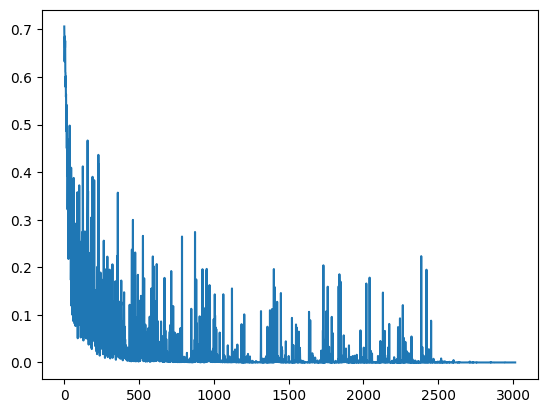

In [ ]:
plt.plot(train_loss_set)

In [ ]:
df = pd.read_csv("Constraint_Train.csv")
val_df = pd.read_csv("Constraint_Val.csv")
test_df = pd.read_csv("english_test_with_labels.csv")
test_label_df = pd.read_csv('english_test_with_labels.csv')

In [ ]:
def map_label(row):
  return 0 if row['label']=='real' else 1

df['label_encoded'] = df.apply(lambda x: map_label(x), 1)
val_df['label_encoded'] = val_df.apply(lambda x: map_label(x), 1)

In [ ]:
train_sentences = df.tweet.values
train_token_ids = df.id.values
val_sentences = val_df.tweet.values
val_token_ids = val_df.id.values
test_sentences = test_df.tweet.values
test_token_ids = test_df.id.values
train_sentences = [sentence + " [SEP] [CLS]" for sentence in train_sentences]
train_labels = df.label_encoded.values
val_sentences = [sentence + " [SEP] [CLS]" for sentence in val_sentences]
val_labels = val_df.label_encoded.values
test_sentences = [sentence + " [SEP] [CLS]" for sentence in test_sentences]
MAX_LEN = 128
batch_size = 48

In [ ]:
def get_dataloader(network, train_sentences, val_sentences, train_labels, val_labels, test_sentences, train_token_ids, val_token_ids, test_token_ids):
  dic = {"XLNET": "xlnet-base-cased", "ROBERT": "roberta-base", "XLM-ROBERT": "xlm-roberta-base", "DeBERTa": "microsoft/deberta-base", "Electra": "google/electra-base-discriminator"}
  if network=='XLNET':
    tokenizer = XLNetTokenizer.from_pretrained(dic[network], do_lower_case=True)
  elif network=='DeBERTa':
    tokenizer = DebertaTokenizer.from_pretrained(dic[network], do_lower_case=True)
  elif network=='Electra':
    tokenizer = ElectraTokenizer.from_pretrained(dic[network], do_lower_case=True)
  elif network=='XLM-ROBERT':
    tokenizer = RobertaTokenizerFast.from_pretrained(dic[network], do_lower_case=True)
  else:
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True) 

  tokenized_train_texts = [tokenizer.tokenize(sent) for sent in train_sentences]
  print ("Tokenize the first sentence:")
  print (tokenized_train_texts[0])

  tokenized_val_texts = [tokenizer.tokenize(sent) for sent in val_sentences]
  tokenized_test_texts = [tokenizer.tokenize(sent) for sent in test_sentences]
  input_train_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_train_texts]
  input_val_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_val_texts]
  input_test_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_test_texts]

  input_train_ids = pad_sequences(input_train_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
  input_val_ids = pad_sequences(input_val_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
  input_test_ids = pad_sequences(input_test_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

  # Create attention masks
  train_attention_masks = []

  # Create a mask of 1s for each token followed by 0s for padding
  for seq in input_train_ids:
    seq_mask = [float(i>0) for i in seq]
    train_attention_masks.append(seq_mask)
  train_masks = np.array(train_attention_masks)

  # Create attention masks
  val_attention_masks = []

  # Create a mask of 1s for each token followed by 0s for padding
  for seq in input_val_ids:
    seq_mask = [float(i>0) for i in seq]
    val_attention_masks.append(seq_mask)
  validation_masks = np.array(val_attention_masks)

  # Create attention masks
  test_attention_masks = []

  # Create a mask of 1s for each token followed by 0s for padding
  for seq in input_test_ids:
    seq_mask = [float(i>0) for i in seq]
    test_attention_masks.append(seq_mask)
  test_masks = np.array(test_attention_masks)

  train_inputs = torch.tensor(input_train_ids)
  validation_inputs = torch.tensor(input_val_ids)
  test_inputs = torch.tensor(input_test_ids)
  train_labels = torch.tensor(train_labels)
  validation_labels = torch.tensor(val_labels)
  train_masks = torch.tensor(train_masks)
  validation_masks = torch.tensor(validation_masks)
  test_masks = torch.tensor(test_masks)

  train_data = TensorDataset(torch.tensor(train_token_ids), train_inputs, train_masks, train_labels)
  train_sampler = RandomSampler(train_data)
  train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

  validation_data = TensorDataset(torch.tensor(val_token_ids), validation_inputs, validation_masks, validation_labels)
  validation_sampler = SequentialSampler(validation_data)
  validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

  test_data = TensorDataset(torch.tensor(test_token_ids), test_inputs, test_masks)
  test_sampler = SequentialSampler(test_data)
  test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

  return train_dataloader, validation_dataloader, test_dataloader

In [ ]:
train_dataloader_XLNET, val_dataloader_XLNET, test_dataloader_XLNET = get_dataloader("BERT", train_sentences, val_sentences, train_labels, val_labels, test_sentences, train_token_ids, val_token_ids, test_token_ids)

Tokenize the first sentence:
['the', 'cdc', 'currently', 'reports', '99', '##0', '##31', 'deaths', '.', 'in', 'general', 'the', 'disc', '##re', '##pan', '##cies', 'in', 'death', 'counts', 'between', 'different', 'sources', 'are', 'small', 'and', 'ex', '##pl', '##ica', '##ble', '.', 'the', 'death', 'toll', 'stands', 'at', 'roughly', '1000', '##00', 'people', 'today', '.', '[SEP]', '[CLS]']


In [ ]:
model3 = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2).cuda()
directory_path = ''
model3.load_state_dict(torch.load('BERT_base_uncased_best_model.ckpt'))
model3.eval()
model3.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
def get_model_preds_labels(model, dataloader, mode='train'):
  data_vectors = []
  labels = []
  ids = []

  with torch.no_grad():
      correct = 0
      total = 0
      for i, batch in enumerate(dataloader):
        batch = tuple(t.to(device) for t in batch)
        if mode=='test':
            token_ids, b_input_ids, b_input_mask = batch
            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
            for point, tk_id in zip(F.softmax(outputs.logits).tolist(), token_ids.tolist()):
              data_vectors.append(point)       
              ids.append(tk_id)     
        else:
          # Unpack the inputs from our dataloader
          token_ids, b_input_ids, b_input_mask, b_labels = batch
          # Forward pass
          outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
          for point, lab, tk_id in zip(F.softmax(outputs.logits).tolist(), b_labels.tolist(), token_ids.tolist()):
            data_vectors.append(point)
            labels.append(lab)
            ids.append(tk_id)

  if mode=='test':
    return data_vectors, ids
  else:
    return data_vectors, labels, ids

In [ ]:
m3, _, train_ids3 = get_model_preds_labels(model3, train_dataloader_XLNET)

<ipython-input-35-9113e251b12a>:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  for point, lab, tk_id in zip(F.softmax(outputs.logits).tolist(), b_labels.tolist(), token_ids.tolist()):


In [ ]:
t3, t_ids3 = get_model_preds_labels(model3, test_dataloader_XLNET, 'test')

<ipython-input-35-9113e251b12a>:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  for point, tk_id in zip(F.softmax(outputs.logits).tolist(), token_ids.tolist()):


In [ ]:
test_pred_labels = ["real" if np.argmax(np.array([each]), 1)[0]==0 else "fake" for each in t3]
test_pred_df = pd.DataFrame({'id': t_ids3, 'predicted_label': test_pred_labels})
test_pred_df = test_label_df[["id", "label"]].merge(test_pred_df, on='id', how='left')
test_pred_df.head()

,id,label,predicted_label
0,1,real,real
1,2,fake,fake
2,3,fake,fake
3,4,real,real
4,5,real,real


In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

## Test result

In [ ]:
confusion_matrix(test_pred_df['label'].values, test_pred_df['predicted_label'].values)

array([[ 939,   81],
       [  14, 1106]])

In [ ]:
accuracy_score(test_pred_df['label'].values, test_pred_df['predicted_label'].values)

0.955607476635514

In [ ]:
precision_score(test_pred_df['label'].values, test_pred_df['predicted_label'].values, average='micro')

0.955607476635514

In [ ]:
recall_score(test_pred_df['label'].values, test_pred_df['predicted_label'].values, average='micro')

0.955607476635514

In [ ]:
f1_score(test_pred_df['label'].values, test_pred_df['predicted_label'].values, average='micro')

0.955607476635514